## Displaying the grad cam results with and without Cut out

Model_1(Training without cutout) : https://colab.research.google.com/drive/1MxDYMBzvpFk85-ChSvrqQG4JAEJOzm6W

Model_1(Training with cutout) : https://colab.research.google.com/drive/1sYfBJBexaLoxDHhnUIgVrfZCWr2cBKOR


## Load necessary functions

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers



Using TensorFlow backend.


In [0]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model


In [0]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [0]:
def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


In [0]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [0]:
def target_category_loss_output_shape(input_shape):
    return input_shape


In [0]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [0]:
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [0]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)


In [0]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Load the base model

In [12]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
from keras.models import load_model
model_new = load_model('/content/drive/My Drive/EVA/Saved_models/6A_model_final_retrained.h5')

W0702 06:42:15.326808 140291843372928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 06:42:15.377411 140291843372928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 06:42:15.447978 140291843372928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 06:42:15.449723 140291843372928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 06:42:15.451183 140291843

In [14]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [16]:
score = model_new.evaluate(test_features, test_labels, batch_size=128)
print (score[1])


10000/10000 [==============================] - 5s 492us/step
0.8404


## Grad cam results without cutout

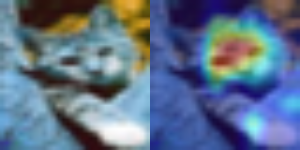

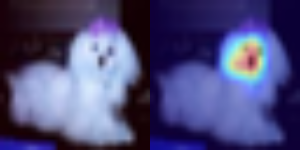

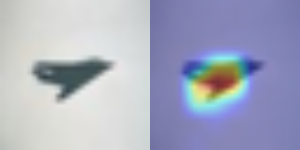

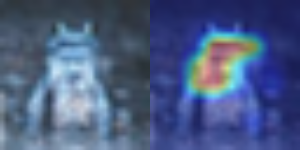

In [21]:
import cv2
from google.colab.patches import cv2_imshow
images = [1905,1988,499,1989]
for j in images:
  x = test_features[j]
  x = np.expand_dims(x, axis=0)
  preds = model_new.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model_new.output[:, class_idx]
  last_conv_layer = model_new.get_layer("conv2d_10")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_new.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = (test_features[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  
  img_resize = cv2.resize(img, (150,150))  
  superimposed_img_resize = cv2.resize(superimposed_img, (150,150))    
  concatimg = cv2.hconcat([img_resize,superimposed_img_resize])  
  cv2_imshow(concatimg)
  cv2.waitKey(0) 


## Load the trained model with CutOut

In [0]:
model_new2 = load_model('/content/drive/My Drive/EVA/Saved_models/6A_with_cutout__model_final_retrained.h5')

In [24]:
score = model_new2.evaluate(test_features, test_labels, batch_size=128)
print (score[1])


10000/10000 [==============================] - 3s 286us/step
0.8739


## Grad Cam with Cut out

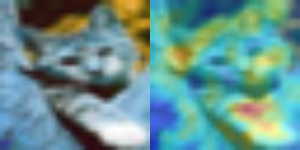

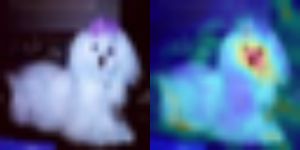

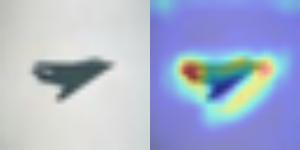

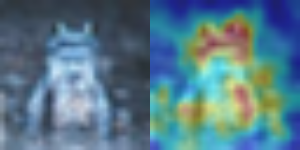

In [25]:
import cv2
from google.colab.patches import cv2_imshow
images = [1905,1988,499,1989]
for j in images:
  x = test_features[j]
  x = np.expand_dims(x, axis=0)
  preds = model_new2.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model_new2.output[:, class_idx]
  last_conv_layer = model_new2.get_layer("conv2d_7")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_new2.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(48):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = (test_features[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  img_resize = cv2.resize(img, (150,150))  
  superimposed_img_resize = cv2.resize(superimposed_img, (150,150))   
  #concatimg = cv2.hconcat([img,superimposed_img])
  concatimg = cv2.hconcat([img_resize,superimposed_img_resize])  
  cv2_imshow(concatimg)
  cv2.waitKey(0)  
